In [18]:
import os
import pandas as pd

# Caminho para a pasta de imagens
images_path = '/teamspace/studios/this_studio/unsupervised_disaster/extracted_data/images'

# Função para processar os nomes das imagens
def process_image_metadata(images_folder):
    data = []

    # Iterar sobre todos os arquivos na pasta de imagens
    for filename in os.listdir(images_folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Separar informações do nome da imagem
            parts = filename.split('_')
            disaster_type = parts[0]  # Exemplo: 'guatemala-volcano' ou 'socal-fire'
            disaster_status = "Com desastre" if "post" in parts[-2] else "Sem desastre"
            image_reference = os.path.splitext(filename)[0]  # Nome sem extensão
            
            # Adicionar informações à lista
            data.append({
                "Image Reference": image_reference,
                "Image Name": filename,
                "Disaster Type": disaster_type,
                "Disaster Status": disaster_status
            })
    
    # Criar DataFrame
    df = pd.DataFrame(data)
    return df

# Processar imagens e criar DataFrame
image_metadata_df = process_image_metadata(images_path)

In [19]:
image_metadata_df.shape

(5598, 4)

In [20]:
# Contagem por tipo de desastre natural
disaster_counts = image_metadata_df['Disaster Type'].value_counts()

# Contagem de imagens com desastre e sem desastre (total e por tipo de desastre)
status_counts_total = image_metadata_df['Disaster Status'].value_counts()
status_counts_by_disaster = image_metadata_df.groupby(['Disaster Type', 'Disaster Status']).size()

# Exibir os resultados
print("Contagem por tipo de desastre natural:")
print(disaster_counts)

print("\nContagem total de imagens com desastre e sem desastre:")
print(status_counts_total)

print("\nContagem de imagens com desastre e sem desastre por tipo de desastre:")
print(status_counts_by_disaster)

Contagem por tipo de desastre natural:
Disaster Type
socal-fire             1646
hurricane-michael       686
hurricane-florence      638
hurricane-harvey        638
midwest-flooding        558
hurricane-matthew       476
santa-rosa-wildfire     452
mexico-earthquake       242
palu-tsunami            226
guatemala-volcano        36
Name: count, dtype: int64

Contagem total de imagens com desastre e sem desastre:
Disaster Status
Com desastre    2799
Sem desastre    2799
Name: count, dtype: int64

Contagem de imagens com desastre e sem desastre por tipo de desastre:
Disaster Type        Disaster Status
guatemala-volcano    Com desastre        18
                     Sem desastre        18
hurricane-florence   Com desastre       319
                     Sem desastre       319
hurricane-harvey     Com desastre       319
                     Sem desastre       319
hurricane-matthew    Com desastre       238
                     Sem desastre       238
hurricane-michael    Com desastre       3

In [21]:
# Lista das classes desejadas
classes_desejadas = ['santa-rosa-wildfire']

# Filtrar o dataset para conter apenas as classes desejadas
image_metadata_df = image_metadata_df[image_metadata_df['Disaster Type'].isin(classes_desejadas)]

# Exibir as primeiras linhas do dataset filtrado
print(image_metadata_df.head())

                                 Image Reference  \
3500  santa-rosa-wildfire_00000002_post_disaster   
3501   santa-rosa-wildfire_00000002_pre_disaster   
3502  santa-rosa-wildfire_00000003_post_disaster   
3503   santa-rosa-wildfire_00000003_pre_disaster   
3504  santa-rosa-wildfire_00000004_post_disaster   

                                          Image Name        Disaster Type  \
3500  santa-rosa-wildfire_00000002_post_disaster.png  santa-rosa-wildfire   
3501   santa-rosa-wildfire_00000002_pre_disaster.png  santa-rosa-wildfire   
3502  santa-rosa-wildfire_00000003_post_disaster.png  santa-rosa-wildfire   
3503   santa-rosa-wildfire_00000003_pre_disaster.png  santa-rosa-wildfire   
3504  santa-rosa-wildfire_00000004_post_disaster.png  santa-rosa-wildfire   

     Disaster Status  
3500    Com desastre  
3501    Sem desastre  
3502    Com desastre  
3503    Sem desastre  
3504    Com desastre  


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [23]:
# Configurações gerais
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Preparação dos dados
df = image_metadata_df.copy()
df['Image Path'] = df['Image Name'].apply(lambda x: os.path.join(images_path, x))
df['Label'] = df['Disaster Status'].map({'Com desastre': 1, 'Sem desastre': 0})

# Filtrar apenas imagens com desastre
#df = df[df['Label'] == 1].reset_index(drop=True)

# Divisão em treino e validação
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)

In [24]:
# Classe que o GPT criou para organizar o dataset
class DisasterDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image Path']
        label = self.dataframe.iloc[idx]['Label']
        disaster_type = self.dataframe.iloc[idx]['Disaster Type']
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        # Retorna também o disaster_type (string)
        return image, torch.tensor(label, dtype=torch.float32), disaster_type


In [25]:
# Transformações 
data_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [26]:
# Criar datasets e dataloaders
train_dataset = DisasterDataset(train_df, transform=data_transforms)
val_dataset = DisasterDataset(val_df, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder_bn1 = nn.BatchNorm2d(64)
        
        # Mantemos a lógica do encoder original:
        # 224x224 -> (layer1, stride=1) -> 64@224x224
        self.layer1 = ResidualBlock(64, 64, stride=1)
        # 224->112
        self.layer2 = ResidualBlock(64, 128, stride=2)
        # 112->56
        self.layer3 = ResidualBlock(128, 256, stride=2)
        # 56->28
        self.layer4 = ResidualBlock(256, 256, stride=2)

        # Após o encoder, temos (256,28,28)
        # Achatar para o espaço latente
        self.flatten_dim = 256 * 28 * 28
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder
        # A partir do latente z, projetar de volta para (256,28,28)
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)

        # Decodificador simétrico:
        # Passos de upsampling: 28->56->112->224
        # Em cada passo, um bloco residual corrige a dimensão de canais para "inverter" o caminho do encoder
        # Primeiro bloco (inverter layer4): Manteve 256 canais lá, mantemos 256 aqui
        self.decoder_block4 = ResidualBlock(256, 256, stride=1)  # Após upsample 28->56
        # Segundo bloco (inverter layer3): Antes era 128->256, agora 256->128
        self.decoder_block3 = ResidualBlock(256, 128, stride=1)  # Após upsample 56->112
        # Terceiro bloco (inverter layer2): Antes era 64->128, agora 128->64
        self.decoder_block2 = ResidualBlock(128, 64, stride=1)   # Após upsample 112->224
        # Quarto bloco (inverter layer1): Antes era 64->64, mantemos 64->64 para refinar
        self.decoder_block1 = ResidualBlock(64, 64, stride=1)

        # Camada final para chegar a 3 canais
        self.decoder_output = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def encode(self, x):
        x = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        x = self.layer1(x)  # (64,224,224)
        x = self.layer2(x)  # (128,112,112)
        x = self.layer3(x)  # (256,56,56)
        x = self.layer4(x)  # (256,28,28)
        x = torch.flatten(x, 1)  # (N, 256*28*28)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)                # (N, 256*28*28)
        x = x.view(x.size(0), 256, 28, 28)   # (N,256,28,28)

        # Upsample 28->56
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False) # (256,56,56)
        x = self.decoder_block4(x)  # (256,56,56)

        # Upsample 56->112
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False) # (256,112,112)
        x = self.decoder_block3(x)  # (128,112,112)

        # Upsample 112->224
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False) # (128,224,224)
        x = self.decoder_block2(x)  # (64,224,224)

        # Refinar mais um bloco (simétrico a layer1)
        x = self.decoder_block1(x)  # (64,224,224)

        # Saída final
        x = self.decoder_output(x)  # (3,224,224)
        x = torch.sigmoid(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        # Clamping aqui, antes de reparametrizar
        logvar = torch.clamp(logvar, min=-10, max=10)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar, z



In [45]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstrução: MSE com redução média
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    # Divergência KL
    # Clamping logvar para evitar valores extremos
    logvar = torch.clamp(logvar, min=-10, max=10)
    
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - torch.exp(logvar))

    # Adicionar prints para depuração
    #print(f"Recon Loss: {recon_loss.item()}, KL Divergence: {kl_div.item()}")
    
    return recon_loss + kl_div


In [46]:
from torch.optim import lr_scheduler

# Inicializar o modelo, otimizador e hiperparâmetros
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = ConvVAE(latent_dim=128).to(device)

# Usar AdamW como otimizador
optimizer = torch.optim.AdamW(vae.parameters(), lr=0.0001)

# Scheduler para o otimizador
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [47]:
from tqdm import tqdm

epochs = 100

# Diretório para salvar os checkpoints
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_loss = float('inf')

# Armazenar perdas de treinamento e validação
train_losses = []
val_losses = []

for epoch in range(epochs):
    vae.train()
    epoch_loss = 0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
        for X, y, dt in train_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            recon, mu, logvar, z = vae(X)
            loss = vae_loss(recon, X, mu, logvar)
            epoch_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradiente Clipping
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

            optimizer.step()

            # Atualizar barra de progresso
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

    # Atualizar o scheduler
    scheduler.step()

    # Calcular perda média de treinamento
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Avaliar no conjunto de validação
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val, dt_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            recon_val, mu_val, logvar_val, z_val = vae(X_val)
            loss_val = vae_loss(recon_val, X_val, mu_val, logvar_val)
            val_loss += loss_val.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Salvar o modelo se a perda de validação melhorar
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(vae.state_dict(), os.path.join(checkpoint_dir, 'best_vae.pth'))
        print(f"Modelo salvo na epoch {epoch + 1} com Val Loss: {avg_val_loss:.4f}")

# Plotar as perdas por época
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, marker='x', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()


Epoch 1/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=5.91]  


Epoch 1, Loss: 142.1601, Val Loss: 3.2847
Modelo salvo na epoch 1 com Val Loss: 3.2847


Epoch 2/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=2.44]


Epoch 2, Loss: 3.5757, Val Loss: 2.2889
Modelo salvo na epoch 2 com Val Loss: 2.2889


Epoch 3/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.67] 


Epoch 3, Loss: 1.2569, Val Loss: 1.0864
Modelo salvo na epoch 3 com Val Loss: 1.0864


Epoch 4/100: 100%|██████████| 12/12 [00:19<00:00,  1.63s/batch, loss=0.681]


Epoch 4, Loss: 0.8510, Val Loss: 0.7591
Modelo salvo na epoch 4 com Val Loss: 0.7591


Epoch 5/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.776]


Epoch 5, Loss: 0.7479, Val Loss: 0.7131
Modelo salvo na epoch 5 com Val Loss: 0.7131


Epoch 6/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.427]


Epoch 6, Loss: 0.6974, Val Loss: 0.6987
Modelo salvo na epoch 6 com Val Loss: 0.6987


Epoch 7/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.628]


Epoch 7, Loss: 0.7064, Val Loss: 0.6855
Modelo salvo na epoch 7 com Val Loss: 0.6855


Epoch 8/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.838]


Epoch 8, Loss: 0.7113, Val Loss: 0.6739
Modelo salvo na epoch 8 com Val Loss: 0.6739


Epoch 9/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.516]


Epoch 9, Loss: 0.6872, Val Loss: 0.6668
Modelo salvo na epoch 9 com Val Loss: 0.6668


Epoch 10/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.547]


Epoch 10, Loss: 0.6865, Val Loss: 0.6655
Modelo salvo na epoch 10 com Val Loss: 0.6655


Epoch 11/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=1.03] 


Epoch 11, Loss: 0.7147, Val Loss: 0.6637
Modelo salvo na epoch 11 com Val Loss: 0.6637


Epoch 12/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.587]


Epoch 12, Loss: 0.6873, Val Loss: 0.6631
Modelo salvo na epoch 12 com Val Loss: 0.6631


Epoch 13/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.598]


Epoch 13, Loss: 0.6870, Val Loss: 0.6620
Modelo salvo na epoch 13 com Val Loss: 0.6620


Epoch 14/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.489]


Epoch 14, Loss: 0.6802, Val Loss: 0.6615
Modelo salvo na epoch 14 com Val Loss: 0.6615


Epoch 15/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.614]


Epoch 15, Loss: 0.6875, Val Loss: 0.6612
Modelo salvo na epoch 15 com Val Loss: 0.6612


Epoch 16/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.676]


Epoch 16, Loss: 0.6908, Val Loss: 0.6610
Modelo salvo na epoch 16 com Val Loss: 0.6610


Epoch 17/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.457]


Epoch 17, Loss: 0.6776, Val Loss: 0.6610
Modelo salvo na epoch 17 com Val Loss: 0.6610


Epoch 18/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.475]


Epoch 18, Loss: 0.6788, Val Loss: 0.6608
Modelo salvo na epoch 18 com Val Loss: 0.6608


Epoch 19/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.66] 


Epoch 19, Loss: 0.6896, Val Loss: 0.6610


Epoch 20/100: 100%|██████████| 12/12 [00:19<00:00,  1.63s/batch, loss=0.417]


Epoch 20, Loss: 0.6752, Val Loss: 0.6609


Epoch 21/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.451]


Epoch 21, Loss: 0.6772, Val Loss: 0.6607
Modelo salvo na epoch 21 com Val Loss: 0.6607


Epoch 22/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.507]


Epoch 22, Loss: 0.6803, Val Loss: 0.6606
Modelo salvo na epoch 22 com Val Loss: 0.6606


Epoch 23/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.561]


Epoch 23, Loss: 0.6834, Val Loss: 0.6604
Modelo salvo na epoch 23 com Val Loss: 0.6604


Epoch 24/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.568]


Epoch 24, Loss: 0.6838, Val Loss: 0.6604
Modelo salvo na epoch 24 com Val Loss: 0.6604


Epoch 25/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=1.19] 


Epoch 25, Loss: 0.7211, Val Loss: 0.6604


Epoch 26/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.748]


Epoch 26, Loss: 0.6948, Val Loss: 0.6604


Epoch 27/100: 100%|██████████| 12/12 [00:19<00:00,  1.60s/batch, loss=0.427]


Epoch 27, Loss: 0.6754, Val Loss: 0.6604


Epoch 28/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.959]


Epoch 28, Loss: 0.7071, Val Loss: 0.6603
Modelo salvo na epoch 28 com Val Loss: 0.6603


Epoch 29/100: 100%|██████████| 12/12 [00:19<00:00,  1.63s/batch, loss=0.589]


Epoch 29, Loss: 0.6850, Val Loss: 0.6604


Epoch 30/100: 100%|██████████| 12/12 [00:19<00:00,  1.60s/batch, loss=0.593]


Epoch 30, Loss: 0.6852, Val Loss: 0.6604


Epoch 31/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.622]


Epoch 31, Loss: 0.6870, Val Loss: 0.6605


Epoch 32/100: 100%|██████████| 12/12 [00:19<00:00,  1.60s/batch, loss=0.439]


Epoch 32, Loss: 0.6763, Val Loss: 0.6607


Epoch 33/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.739]


Epoch 33, Loss: 0.6943, Val Loss: 0.6605


Epoch 34/100: 100%|██████████| 12/12 [00:19<00:00,  1.60s/batch, loss=1.14] 


Epoch 34, Loss: 0.7180, Val Loss: 0.6604


Epoch 35/100: 100%|██████████| 12/12 [00:19<00:00,  1.63s/batch, loss=0.678]


Epoch 35, Loss: 0.6903, Val Loss: 0.6603
Modelo salvo na epoch 35 com Val Loss: 0.6603


Epoch 36/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.561]


Epoch 36, Loss: 0.6833, Val Loss: 0.6604


Epoch 37/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.869]


Epoch 37, Loss: 0.7020, Val Loss: 0.6604


Epoch 38/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=1.15] 


Epoch 38, Loss: 0.7187, Val Loss: 0.6604


Epoch 39/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.746]


Epoch 39, Loss: 0.6942, Val Loss: 0.6603


Epoch 40/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.876]


Epoch 40, Loss: 0.7021, Val Loss: 0.6604


Epoch 41/100: 100%|██████████| 12/12 [00:19<00:00,  1.60s/batch, loss=0.919]


Epoch 41, Loss: 0.7047, Val Loss: 0.6603
Modelo salvo na epoch 41 com Val Loss: 0.6603


Epoch 42/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.533]


Epoch 42, Loss: 0.6816, Val Loss: 0.6603


Epoch 43/100: 100%|██████████| 12/12 [00:19<00:00,  1.63s/batch, loss=0.762]


Epoch 43, Loss: 0.6954, Val Loss: 0.6603


Epoch 44/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.685]


Epoch 44, Loss: 0.6906, Val Loss: 0.6602
Modelo salvo na epoch 44 com Val Loss: 0.6602


Epoch 45/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.945]


Epoch 45, Loss: 0.7062, Val Loss: 0.6603


Epoch 46/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=1.05] 


Epoch 46, Loss: 0.7125, Val Loss: 0.6603


Epoch 47/100: 100%|██████████| 12/12 [00:19<00:00,  1.60s/batch, loss=0.518]


Epoch 47, Loss: 0.6806, Val Loss: 0.6603


Epoch 48/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.98] 


Epoch 48, Loss: 0.7083, Val Loss: 0.6603


Epoch 49/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.664]


Epoch 49, Loss: 0.6894, Val Loss: 0.6603


Epoch 50/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.606]


Epoch 50, Loss: 0.6859, Val Loss: 0.6603


Epoch 51/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.626]


Epoch 51, Loss: 0.6871, Val Loss: 0.6603


Epoch 52/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.891]


Epoch 52, Loss: 0.7030, Val Loss: 0.6603


Epoch 53/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.569]


Epoch 53, Loss: 0.6837, Val Loss: 0.6604


Epoch 54/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.64] 


Epoch 54, Loss: 0.6879, Val Loss: 0.6603


Epoch 55/100: 100%|██████████| 12/12 [00:19<00:00,  1.63s/batch, loss=0.9]  


Epoch 55, Loss: 0.7035, Val Loss: 0.6603


Epoch 56/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.503]


Epoch 56, Loss: 0.6797, Val Loss: 0.6604


Epoch 57/100: 100%|██████████| 12/12 [00:19<00:00,  1.63s/batch, loss=0.602]


Epoch 57, Loss: 0.6857, Val Loss: 0.6603


Epoch 58/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.589]


Epoch 58, Loss: 0.6848, Val Loss: 0.6603


Epoch 59/100: 100%|██████████| 12/12 [00:19<00:00,  1.63s/batch, loss=0.462]


Epoch 59, Loss: 0.6775, Val Loss: 0.6604


Epoch 60/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.548]


Epoch 60, Loss: 0.6824, Val Loss: 0.6603


Epoch 61/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.821]


Epoch 61, Loss: 0.6987, Val Loss: 0.6602
Modelo salvo na epoch 61 com Val Loss: 0.6602


Epoch 62/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.417]


Epoch 62, Loss: 0.6746, Val Loss: 0.6603


Epoch 63/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.722]


Epoch 63, Loss: 0.6928, Val Loss: 0.6603


Epoch 64/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.688]


Epoch 64, Loss: 0.6908, Val Loss: 0.6604


Epoch 65/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=1.03] 


Epoch 65, Loss: 0.7112, Val Loss: 0.6603


Epoch 66/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.96] 


Epoch 66, Loss: 0.7070, Val Loss: 0.6603


Epoch 67/100: 100%|██████████| 12/12 [00:19<00:00,  1.63s/batch, loss=0.706]


Epoch 67, Loss: 0.6919, Val Loss: 0.6603


Epoch 68/100: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.814]


Epoch 68, Loss: 0.6984, Val Loss: 0.6603


Epoch 69/100: 100%|██████████| 12/12 [00:19<00:00,  1.63s/batch, loss=0.409]


Epoch 69, Loss: 0.6741, Val Loss: 0.6604


Epoch 70/100: 100%|██████████| 12/12 [00:19<00:00,  1.60s/batch, loss=0.64] 


Epoch 70, Loss: 0.6879, Val Loss: 0.6603


Epoch 71/100: 100%|██████████| 12/12 [00:19<00:00,  1.62s/batch, loss=0.72] 


Epoch 71, Loss: 0.6926, Val Loss: 0.6603


Epoch 72/100:  58%|█████▊    | 7/12 [00:12<00:08,  1.73s/batch, loss=0.873]


KeyboardInterrupt: 

In [49]:
import numpy as np

# Após o treinamento, extrair os vetores latentes finais
vae.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_vae.pth')))
vae.eval()

latent_vectors = []
labels = []
disaster_types = []

with torch.no_grad():
    with tqdm(total=len(train_loader), desc="Extraindo Vetores Latentes", unit="batch") as pbar:
        for X, y, dt in train_loader:
            X = X.to(device)
            
            # Forward pass
            recon, mu, logvar, z = vae(X)
            
            # Salvar apenas mu como representação latente
            latent_vectors.append(mu.cpu().numpy())
            labels.append(y.cpu().numpy())
            disaster_types.extend(dt)  # Supondo que dt é um iterable

            pbar.update(1)

# Concatenar todas as amostras
latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)
# Ajustar disaster_types conforme necessário
# Por exemplo, se dt for uma lista de strings ou categorias:
# disaster_types = [item for sublist in disaster_types for item in sublist]

# Salvar os vetores latentes e rótulos para uso posterior
np.save('latent_vectors.npy', latent_vectors)
np.save('labels.npy', labels)
# Dependendo do formato de disaster_types, salvar de forma apropriada
# np.save('disaster_types.npy', disaster_types)

Extraindo Vetores Latentes: 100%|██████████| 12/12 [00:12<00:00,  1.05s/batch]


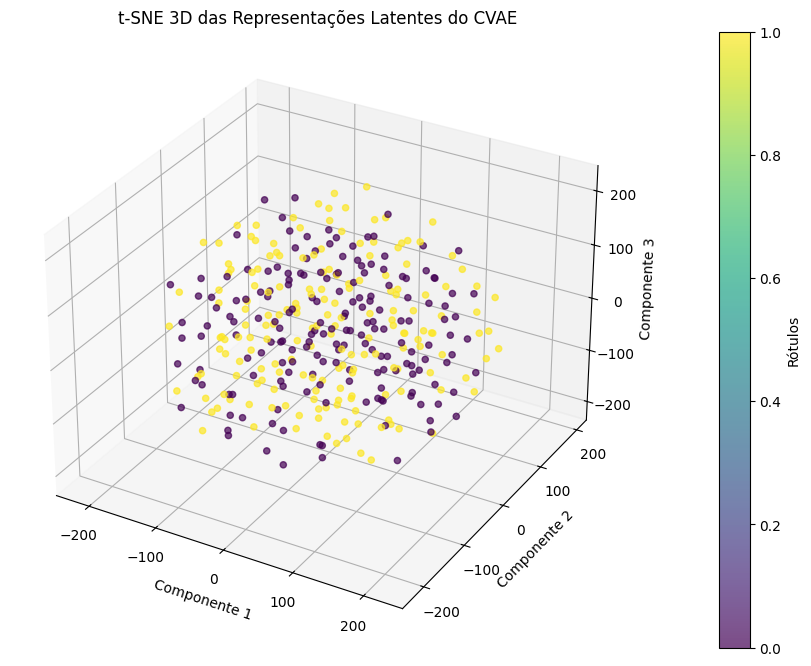

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Carregar os vetores latentes e rótulos
latent_vectors = np.load('latent_vectors.npy')
labels = np.load('labels.npy')
# disaster_types = np.load('disaster_types.npy')  # Se salvo

# Aplicar t-SNE em 3D
tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=3000)
latent_tsne_3d = tsne.fit_transform(latent_vectors)

# Plotar em 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot dos pontos no espaço 3D
scatter = ax.scatter(
    latent_tsne_3d[:, 0], latent_tsne_3d[:, 1], latent_tsne_3d[:, 2],
    c=labels, cmap='viridis', alpha=0.7
)

# Adicionar rótulos e título
ax.set_title('t-SNE 3D das Representações Latentes do CVAE')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

# Adicionar barra de cores
cbar = fig.colorbar(scatter, ax=ax, pad=0.1, label='Rótulos')

plt.show()


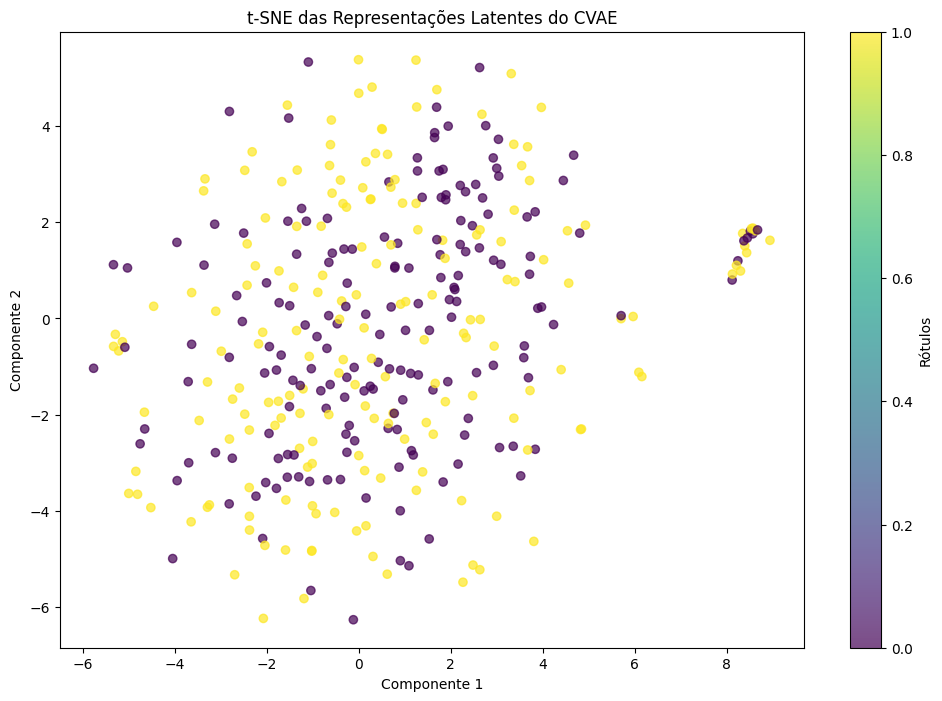

In [51]:
# Carregar os vetores latentes e rótulos
latent_vectors = np.load('latent_vectors.npy')
labels = np.load('labels.npy')
# disaster_types = np.load('disaster_types.npy')  # Se salvo

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
latent_tsne = tsne.fit_transform(latent_vectors)

# Plotar
plt.figure(figsize=(12, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Rótulos')
plt.title('t-SNE das Representações Latentes do CVAE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()